In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers
!pip3 install fairseq
!pip3 install fastbpe

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [ ]:
!ln -s "/content/drive/MyDrive/VNPT/ChatbotATTT/PhoBERT_base_transformers.tar.gz" "/content/"

ln: failed to create symbolic link '/content/PhoBERT_base_transformers.tar.gz': File exists


In [ ]:
# !wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


In [ ]:
!ls PhoBERT_base_transformers

bpe.codes  config.json	dict.txt  model.bin


In [ ]:
import torch
import argparse

from transformers import RobertaConfig
from transformers import RobertaModel

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

# Load model
config = RobertaConfig.from_pretrained(
    "PhoBERT_base_transformers/config.json"
)
phobert = RobertaModel.from_pretrained(
    "PhoBERT_base_transformers/model.bin",
    config=config
)

# Load BPE encoder 
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str
)
# args = parser.parse_args('--bpe-codes phobert/bpe.codes'.split())
args = parser.parse_args('--bpe-codes PhoBERT_base_transformers/bpe.codes'.split())

bpe = fastBPE(args)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Load the dictionary  
vocab = Dictionary()
vocab.add_from_file("PhoBERT_base_transformers/dict.txt")

# INPUT TEXT IS WORD-SEGMENTED!
line = "Tôi là sinh_viên trường đại_học Công_nghệ ."  

# Encode the line using fastBPE & Add prefix <s> and suffix </s> 
subwords = '<s> ' + bpe.encode(line) + ' </s>'

# Map subword tokens to corresponding indices in the dictionary
input_ids = vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist()

# Convert into torch tensor
all_input_ids = torch.tensor([input_ids], dtype=torch.long)

# Extract features  
with torch.no_grad():  
    features = phobert(all_input_ids)  
  
# Represent each word by the contextualized embedding of its first subword token  
# i. Get indices of the first subword tokens of words in the input sentence 
listSWs = subwords.split()  
firstSWindices = []  
for ind in range(1, len(listSWs) - 1):  
    if not listSWs[ind - 1].endswith("@@"):  
        firstSWindices.append(ind)  

# ii. Extract the corresponding contextualized embeddings  
words = line.split()  
assert len(firstSWindices) == len(words)  
vectorSize = features[0][0, 0, :].size()[0]  
for word, index in zip(words, firstSWindices):  
    print(word + " --> " + " ".join([str(features[0][0, index, :][_ind].item()) for _ind in range(vectorSize)]))
    # print(word + " --> " + listSWs[index] + " --> " + " ".join([str(features[0][0, index, :][_ind].item()) for _ind in range(vectorSize)]))

Tôi --> -0.030567409470677376 0.87613445520401 -0.4924100339412689 -0.9476602673530579 0.02015243098139763 0.5592480301856995 0.2763005197048187 0.01437461469322443 0.09938712418079376 -0.08303448557853699 -0.44714874029159546 0.27915751934051514 -0.10159946978092194 -0.25028982758522034 0.17597085237503052 -0.08196261525154114 0.03303902596235275 0.3587888479232788 0.029551437124609947 0.19151173532009125 -0.14574287831783295 -0.2245657593011856 0.08834182471036911 -0.07890170067548752 -0.305070161819458 -0.2082889974117279 0.4843690097332001 -0.04391155019402504 -0.22101444005966187 -0.18358932435512543 0.1879049390554428 -0.032220639288425446 0.3729306757450104 -0.2990648150444031 0.2838117182254791 0.4236410856246948 -0.30126112699508667 -0.4472338557243347 0.5702935457229614 -0.10562129318714142 0.5556037425994873 0.7379555702209473 0.5314483642578125 -0.09778386354446411 -0.23535698652267456 0.538425862789154 0.343632310628891 0.2269972413778305 0.02095741219818592 0.123588487505

In [ ]:
label_names = ['Chinh tri Xa hoi','Doi song','Khoa hoc','Kinh doanh','Phap luat','Suc khoe','The gioi','The thao','Van hoa','Vi tinh']

In [ ]:
train_path = '/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Train_Full/*/*.txt'
test_path = '/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Test_Full/Test_Full/*/*.txt'

In [ ]:
import glob2
from tqdm import tqdm

train_path = '/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Train_Full/*/*.txt'
test_path = '/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Test_Full/Test_Full/*/*.txt'

# Hàm đọc file txt
def read_txt(path):
  with open(path, 'r', encoding='utf-16') as f:
    data = f.read()
  return data

# Hàm tạo dữ liệu huấn luyện cho tập train và test
def make_data(path):
  texts = []
  labels = []
  for file_path in tqdm(glob2.glob(train_path)):
    try:
      content = read_txt(file_path)
      label = file_path.split('/')[1]
      texts.append(content)
      labels.append(label)
    except:
      next
  return texts, labels

text_train, label_train = make_data(train_path)
text_test, label_test = make_data(test_path)


In [ ]:
import os
from tqdm import tqdm
import numpy as np

# Hàm đọc file txt
def read_txt(path):
  with open(path, 'r', encoding='utf-16') as f:
    data = f.read()
  return data

def loaddata(dataset, num):
    texts = []
    labels = []   
    #lặp qua các folder trong thư mục datasets
    # count = np.array([0,0,0,0,0,0,0,0,0,0 ], dtype = 'int32')
    i = 0
    for folder in os.listdir(dataset):

        if folder in ['Chinh tri Xa hoi']: label = 0
        elif folder in ['Doi song']: label = 1
        # elif folder in ['Khoa hoc']: label = 2
        # elif folder in ['Kinh doanh']: label = 3
        # elif folder in ['Phap luat']: label = 4
        # elif folder in ['Suc khoe']: label = 5
        # elif folder in ['The gioi']: label = 6
        # elif folder in ['The thao']: label = 7
        # elif folder in ['Van hoa']: label = 8
        # elif folder in ['Vi tinh']: label = 9
        if i <10:  
          count = 0
          i+=1
          for file in tqdm(os.listdir(os.path.join(dataset, folder))):

              path_ = os.path.join(os.path.join(dataset, folder), file)

              if count < 1000:  
                content = read_txt(path_)
                # label = path_.split('/')[num]
                # [0]

                texts.append(content)
                labels.append(label)
                count +=1
          
    return texts, labels


In [ ]:
text_train_, label_train_ = loaddata('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Train_Full/2', 8)
text_test_, label_test_ = loaddata('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/Test_Full/Test_Full/2', 9)

In [ ]:
import pickle

def _save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)


# Lưu lại các files
_save_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/text_train_5000.pkl', text_train_)
_save_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/label_train_5000.pkl', label_train_)
_save_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/text_test_5000.pkl', text_test_)
_save_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/label_test_5000.pkl', label_test_)

In [ ]:
import pickle

def _load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj

# # Load lại dữ liệu
# X = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/X1.pkl')
# y = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/y1.pkl')

In [ ]:
text_train_ = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/text_train_5000.pkl')
label_train_ = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/label_train_5000.pkl')
text_test_ = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/text_test_5000.pkl')
label_test_ = _load_pkl('/content/drive/MyDrive/VNPT/ChatbotATTT/VNTCData/500data/label_test_5000.pkl')

In [ ]:
print(len(text_train_))
print(len(label_train_))
print(len(text_test_))
print(len(label_test_))

2000
2000
2000
2000


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
MAX_LEN = 256
tokenizer_ = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def tokenize_and_trim(sent):
  tokens = tokenizer_.tokenize(sent)
  return tokens[:MAX_LEN - 1] + [tokens[-1]]

# tokenized_texts = [tokenize_and_trim(sent) for sent in sentences]

100%|██████████| 231508/231508 [00:00<00:00, 852803.56B/s]


In [ ]:
# tokenizer_ = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenized_texts_train = [tokenize_and_trim(sent) for sent in text_train_]
# print ("Tokenize the first training sentence:")
# print (tokenized_texts_train[0])
input_ids_train = [tokenizer_.convert_tokens_to_ids(x) for x in tokenized_texts_train]

In [ ]:
tokenized_texts_test = [tokenize_and_trim(sent) for sent in text_test_]
# print ("Tokenize the first testing sentence:")
# print (tokenized_texts_test[0])
input_ids_test = [tokenizer_.convert_tokens_to_ids(x) for x in tokenized_texts_test]

In [ ]:
# Đệm thêm vào các chuỗi đầu vào
input_ids_train_ = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
input_ids_test_ = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Tạo mảng chứa các attention mask
attention_masks = []

# Tạo mask chứa các giá trị 1 cho mỗi koten và 0 cho các giá trị đệm
for seq in input_ids_train_:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)


In [ ]:
# !git clone https://github.com/huggingface/transformers.git

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids_train_, label_train_, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids_train_, random_state=2018, test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# lựa chọn batch size sử dụng huấn luyện. Với fine-tuning BERT, các tác giả khuyến nghị đặt giá trị này là 16 hoặc 32
batch_size = 32
# Tạo iterator với DataLoader. Điều này sẽ giúp tiết kiệm bộ nhớ khi huấn luyện. Khác với vòng lặp, với một iterator thì toàn bộ dataset sẽ không cần phải nạp lên bộ nhớ
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
# config = RobertaConfig.from_pretrained(
#     "PhoBERT_base_transformers/config.json", from_tf=False, output_hidden_states=False,
# )

# phobert = RobertaModel.from_pretrained(
#     "PhoBERT_base_transformers/model.bin",
#     config=config
# )
phobert.cuda()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=0)
    (position_embeddings): Embedding(258, 768, padding_idx=0)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [ ]:
from transformers import RobertaForSequenceClassification
phobertClassify = RobertaForSequenceClassification.from_pretrained(
    "PhoBERT_base_transformers/model.bin",
    config=config
)

Some weights of the model checkpoint at PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PhoBERT_base_transformers/model

In [ ]:
phobertClassify.cuda()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [ ]:
param_optimizer = list(phobertClassify.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import random
from tqdm import tqdm_notebook
from transformers import AdamW
# device = device(type='cuda')
epochs = 4
train_loss_set = []

# param_optimizer = list(phobertClassify.named_parameters())
# no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
# optimizer_grouped_parameters = [
#     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
#     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
# ]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)


for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    phobertClassify.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm_notebook(enumerate(train_dataloader)):
        # b_input_ids = batch[0].to(device)
        # b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)
        # b_input_ids = batch[0].cuda() #cuda()
        # b_input_mask = batch[1].cuda() #cuda()
        # b_labels = batch[2].cuda() #cuda()
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        # phobertClassify.zero_grad()
        outputs = phobertClassify(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        train_loss_set.append(loss.item())

        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy() #to('cpu')
        logits_ = np.array(logits, dtype = 'float32')
        label_ids_ = np.array(label_ids, dtype = 'float32')
        tmp_train_accuracy= flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(phobertClassify.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Validation...")
    phobertClassify.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # eval_f1 = 0
    for batch in tqdm_notebook(validation_dataloader):

        batch = tuple(t.cuda() for t in batch)  #to(device)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = phobertClassify(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy() #to('cpu')

            tmp_eval_accuracy= flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            # eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}\n".format(eval_accuracy/nb_eval_steps))
    # print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 4 ========
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 Accuracy: 0.5735
 Average training loss: 0.6694
Running Validation...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



 Accuracy: 0.8214

======== Epoch 2 / 4 ========
Training...



 Accuracy: 0.8383
 Average training loss: 0.4108
Running Validation...



 Accuracy: 0.8795

======== Epoch 3 / 4 ========
Training...



 Accuracy: 0.8843
 Average training loss: 0.3200
Running Validation...



 Accuracy: 0.8839

======== Epoch 4 / 4 ========
Training...



 Accuracy: 0.9123
 Average training loss: 0.2619
Running Validation...



 Accuracy: 0.8929

Training complete!


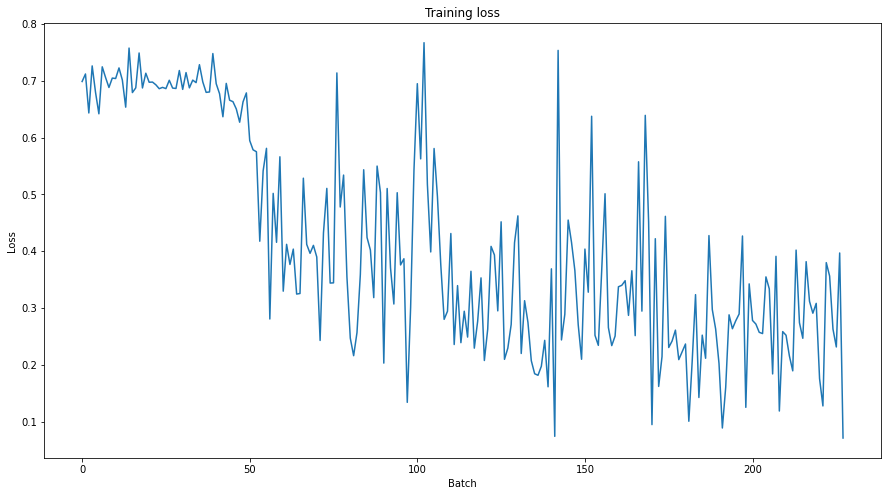

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
attention_masks_test = []
for seq in input_ids_test_:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids_test_)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(label_test_)  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
phobertClassify.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = phobertClassify(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
from functools import reduce

In [ ]:
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])

In [ ]:
labels = reduce(lambda x,y: list(x) + list(y), true_labels)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
auc = roc_auc_score(labels, scores, average = None)

In [ ]:
auc

0.9005

In [ ]:
texts = ["Một chương trình du lịch bao gồm: ăn sáng bánh mì; ăn trưa cơm đĩa; giao lưu với các giáo sư, tiến sĩ... có vẻ không hấp dẫn nhiều người nhưng tỏ ra cuốn hút đối với đông đảo học sinh phổ thông đang chuẩn bị đi thi đại học. Đất Việt Tour (588 Lạc Long Quân, Q.11, TP.HCM) đang giới thiệu tour kiểu này cho học sinh phổ thông trong suốt chuyến đi tham quan một số trường đại học như: Bách khoa, Văn Lang, Kinh tế... và các ký túc xá sinh viên để tìm hiểu về các trường đại học, cũng như không khí sinh hoạt, đời sống của sinh viên. Tour chào giá 85.000 đồng/người!",
"Cô ấy không xứng đáng với anh Trung Có thể cô ấy là người con hiếu thảo, nhưng cách cô ấy làm chứng tỏ không phải là phụ nữ đoan chính. Chỉ 10 ngày ở Việt Nam, ông Việt kiều nọ đã cùng cô ta đến phòng trọ. Và cũng cách đó không lâu cô sẵn sàng đến phòng trọ với anh. Cô ấy không yêu ai cả."]
labels = [0,1]
tokenized_texts = [tokenize_and_trim(text)for text in texts]
input_ids = [tokenizer_.convert_tokens_to_ids(tokenized_text)for tokenized_text in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  masks.append(seq_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(masks)
prediction_labels = torch.tensor(labels)  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

# Put model in evaluation mode
phobertClassify.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = phobertClassify(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = outputs[0].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


In [ ]:
scores = reduce(lambda x,y: x+y,[list(map(np.argmax,p)) for p in predictions])

In [ ]:
for i in range(len(texts)):
  print("Text:" + texts[i] + "\n-----True Label: " + label_names[labels[i]] +"\n-----Predict: " +label_names[scores[i]])

Text:Một chương trình du lịch bao gồm: ăn sáng bánh mì; ăn trưa cơm đĩa; giao lưu với các giáo sư, tiến sĩ... có vẻ không hấp dẫn nhiều người nhưng tỏ ra cuốn hút đối với đông đảo học sinh phổ thông đang chuẩn bị đi thi đại học. Đất Việt Tour (588 Lạc Long Quân, Q.11, TP.HCM) đang giới thiệu tour kiểu này cho học sinh phổ thông trong suốt chuyến đi tham quan một số trường đại học như: Bách khoa, Văn Lang, Kinh tế... và các ký túc xá sinh viên để tìm hiểu về các trường đại học, cũng như không khí sinh hoạt, đời sống của sinh viên. Tour chào giá 85.000 đồng/người!
-----True Label: Chinh tri Xa hoi
-----Predict: Chinh tri Xa hoi
Text:Cô ấy không xứng đáng với anh Trung Có thể cô ấy là người con hiếu thảo, nhưng cách cô ấy làm chứng tỏ không phải là phụ nữ đoan chính. Chỉ 10 ngày ở Việt Nam, ông Việt kiều nọ đã cùng cô ta đến phòng trọ. Và cũng cách đó không lâu cô sẵn sàng đến phòng trọ với anh. Cô ấy không yêu ai cả.
-----True Label: Doi song
-----Predict: Doi song
